# APPLY DENSITY BASED CLUSTERING ON AMAZON FINE FOOD REVIEWS

In [1]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle


import os
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
# Tutorial about

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.shape

Number of data points in our data (10000, 10)


(10000, 10)

In [3]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [4]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [6]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

In [9]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import nltk

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'is', 'having', 'his', 'be', 'aren', 'very', 'then', 'this', "needn't", 'her', 'out', 'themselves', 'have', 'during', 'same', 'ma', 'you', 'down', 'hasn', "weren't", 'yours', 'weren', 'hers', 'they', 'being', 'd', 'he', 'your', "that'll", 'with', "aren't", "couldn't", 'about', 'don', 'couldn', 'after', 'needn', 'before', 'didn', 'had', 'between', 'wasn', 'than', "haven't", "shouldn't", 'mightn', 'and', 'did', 'myself', 'a', "should've", 's', 'ourselves', 'those', "you'll", 'such', 'll', 'ain', 'what', 'hadn', 'yourselves', 'own', 'do', 'itself', 'more', 'does', 're', 'in', 'again', 'some', 'any', 'y', 'for', 'above', 'when', 'both', 'which', 'not', 'should', 'shan', "it's", 'our', 'm', 'so', 'but', 'wouldn', "mustn't", 'just', 'through', 'am', 'by', "don't", 'once', 'who', 'can', 'ours', 'how', 'here', 'me', "wouldn't", 'other', 'yourself', "wasn't", 'we', 'an', 'most', 'theirs', 'she', 'if', 'all', 'these', 'under', 'nor', 'doing', 'there', 'or', 't', 'up', 'where', 've', "hasn't", "

In [10]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''

for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1


In [11]:
final['CleanedText']=final_string
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
#below the processed review can be seen in the CleanedText Column 
print('Shape of final',final.shape)
final.head()

Shape of final (9564, 11)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...,use victor fli bait season cant beat great pro...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...,product avail www amazon com victor trap unrea...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
8695,9526,B00005V3DC,APASCXWTM041,Ed Raton,0,0,1,1350604800,"Good, effective product","Good flavor, unique in all the teas that I've ...",good flavor uniqu tea ive tri tea effect clean...


In [12]:
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
time_sorted_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...
7427,8111,B0000EIE2Z,A3M174IC0VXOS2,Gail Cooke,3,3,1,1075420800,BEST BLUEBERRIES,In the winter when fresh blueberries exceed ou...,winter fresh blueberri exceed food budget dri ...
3481,3783,B00016UX0K,AF1PV3DIC0XM7,Robert Ashton,1,2,1,1081555200,Classic Condiment,Mae Ploy Sweet Chili Sauce is becoming a stand...,mae ploy sweet chili sauc becom standard condi...
6790,7432,B0001E1IME,A2IKCTD1I73PLW,Adeba,2,8,1,1083456000,amazon monopoly/ripoff,love the snack. wanted to buy a bunch.<p>ship...,love snack want buy bunch ship amazon price sn...
1112,1206,B005O072PC,A3BD5B8Y8MY25X,"J. L. K. ""special_k""",13,14,1,1088467200,The best twice baked potatoes you'll ever have!,Perfect year round with just about any meat di...,perfect year round meat dish omaha steak twice...
5893,6381,B000084EKG,A1Z54EM24Y40LL,c2,2,2,1,1090972800,Awesome food!,This is my cat's favorite one. He just licks ...,cat favorit one lick bowl clean whenev get usu...
5888,6376,B000084EKD,A1Z54EM24Y40LL,c2,1,1,0,1090972800,Needs improved,I haven't had a cat yet that liked this one. ...,havent cat yet like one littl interest think s...
5887,6375,B000084EKC,A1Z54EM24Y40LL,c2,1,1,1,1090972800,Great food for all cats!,"According to my cat, this stuff is just great....",accord cat stuff great lick hour eat one love ...
5885,6373,B000084EKA,A1Z54EM24Y40LL,c2,0,0,1,1090972800,Not their best...,I think 9 Lives does a better job on this vari...,think live better job varieti friski say cat f...


# [1]Apply DBSCAN ALGORITHM ON AVG W2V

In [13]:
i=0
list_of_sent=[]
for sent in time_sorted_data['CleanedText'].values:
    list_of_sent.append(sent.split())
    

In [14]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [15]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
#print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4179


In [16]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

9564
50


In [17]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
w2v_std = sc.fit_transform(sent_vectors)
w2v_std.shape

(9564, 50)

In [20]:
w2v_std[0]

array([-1.96489668, -1.12116753,  1.11442848,  3.72114631,  1.46353503,
       -0.60630622,  1.34373942, -2.78484991,  0.88839942, -1.28372542,
       -2.07995672, -3.29275072,  0.2066542 ,  3.55594352,  2.21189529,
       -0.87315992,  3.04122861, -1.57625769, -1.24835729, -1.45103685,
        2.87264511, -0.42115189, -1.41095857, -0.4440813 ,  0.37526484,
       -0.89362966, -1.07427993, -0.73167707, -3.91411896,  1.77065053,
       -2.58400489,  1.63235321,  1.14165933, -0.55925321, -1.41825925,
       -0.03564838,  0.91764043, -0.50502238, -1.91902869, -0.57203017,
       -0.61565708, -1.48358039, -0.71771068, -1.32638811,  1.45799741,
       -0.91593854,  0.31821646,  4.30373033,  0.52546552, -1.06352103])

In [18]:
min_points = 2*w2v_std.shape[1]
print(min_points)

100


In [ ]:
k=(w2v_std-w2v_std[0])**2
k

In [19]:
def neighbours(data,n):
    distances=[]
    for x in data:
        B=np.sort(np.sum((data-x)**2,axis=1),axis=None)
        distances.append(B[n])
    return np.sqrt(np.array(distances))

In [20]:
distances = neighbours(w2v_std,min_points)

In [21]:
distances

array([3.21546548, 2.78429235, 3.44166127, ..., 3.49169065, 6.2921904 ,
       4.22758514])

In [22]:
import matplotlib as plt
distances_sort=np.sort(distances)
points = [i for i in range(w2v_std.shape[0])]


In [23]:
points

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [24]:
type(points)

list

In [25]:
type(distances_sort)

numpy.ndarray

In [26]:
import matplotlib.pyplot as plt

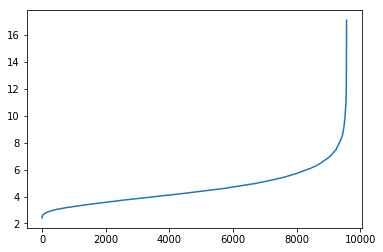

In [27]:
plt.plot(points, distances_sort)

so epsilon should be equal to 7.5

In [28]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=7.5, min_samples=100).fit(w2v_std)


In [29]:
A=time_sorted_data['CleanedText'].values
A

array(['realli good idea final product outstand use decal car window everybodi ask bought decal made two thumb',
       'receiv shipment could hard wait tri product love call instead sticker remov easili daughter design sign print revers use car window print beauti print shop program go lot fun product window everywher surfac like screen comput monitor',
       'winter fresh blueberri exceed food budget dri blue berri fine muffin bread pud also enjoy fruit cereal winter often oatmeal sprinkl blueberri bowl oatmeal wonder cold morn',
       ...,
       'one finest mapl syrup order enjoy bought fanci grade light amber color great tast reorder',
       'disappoint past shipment receiv one coconut water box leak coconut water spoil thank lak',
       'purchas product local store kid love quick easi meal put toaster oven toast min readi eat strong recommend'],
      dtype=object)

In [30]:
clustering.labels_[0:1000]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [32]:
k=set(clustering.labels_)

In [33]:
k

{-1, 0}

In [34]:
len(k)

2

 So here there is only one cluster as -1 corresponds to noise

In [35]:
#Labels of each point
mydict = {i: np.where(clustering.labels_ == 0)[0] }
# Transform this dictionary into list (if you need a list as result)
#dictlist = []
#for key, value in mydict.iteritems():
#temp = [key,value]
#dictlist.append(temp)



In [36]:
mydict

{0: array([   0,    1,    2, ..., 9561, 9562, 9563])}

# PLOTTING WORDCLOUD FOR CLUSTER

In [37]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[0]])))

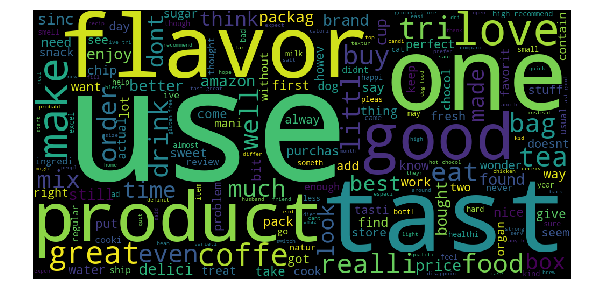

In [38]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

# [2] APPLY DBSCAN ON TFIDFW2V

In [39]:
# TF-IDF weighted Word2Vec
tf_idf_vect = TfidfVectorizer()

# final_tf_idf1 is the sparse matrix with row= sentence, col=word and cell_val = tfidf
final_tf_idf1 = tf_idf_vect.fit_transform(time_sorted_data['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names()
tfidf_vectors = []; 
row=0;
for sent in list_of_sent: 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf1[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_vectors.append(sent_vec)
    row += 1 
    
data = tfidf_vectors

In [40]:
import warnings
warnings.filterwarnings('ignore')
# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
tfidfw2v_std = sc.fit_transform(data)
tfidfw2v_std.shape

(9564, 50)

In [41]:
min_points = 2*tfidfw2v_std.shape[1]
print(min_points)

100


In [43]:
def neighbours1(data1,n):
    distances=[]
    for x in data1:
        B=np.sort(np.sum((data1-x)**2,axis=1),axis=None)
        distances.append(B[n])
    return np.sqrt(np.array(distances))

In [44]:
distances = neighbours1(tfidfw2v_std,min_points)

In [45]:
distances

array([2.33965299, 2.15562549, 2.68067629, ..., 2.68568898, 6.41754594,
       3.06325298])

In [46]:
import matplotlib as plt
distances_sort=np.sort(distances)
points = [i for i in range(tfidfw2v_std.shape[0])]


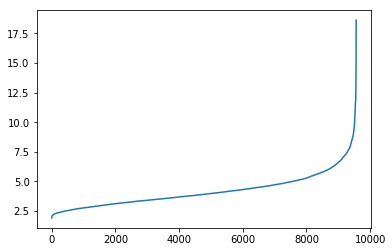

In [47]:
import matplotlib.pyplot as plt
plt.plot(points, distances_sort)

here also epsilon is 7.5

In [48]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=7.5, min_samples=100).fit(tfidfw2v_std)


In [49]:
clustering.labels_[0:10000]

array([0, 0, 0, ..., 0, 0, 0])

In [50]:
set(clustering.labels_)

{-1, 0}

so there is only one cluster

In [51]:
#Labels of each point
mydict = {i: np.where(clustering.labels_ == 0)[0] }
# Transform this dictionary into list (if you need a list as result)
#dictlist = []
#for key, value in mydict.iteritems():
#temp = [key,value]
#dictlist.append(temp)



In [52]:
mydict

{0: array([   0,    1,    2, ..., 9561, 9562, 9563])}

# PLOTTING WORDCLOUD FOR CLUSTER

In [53]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(list(A[mydict[0]])))

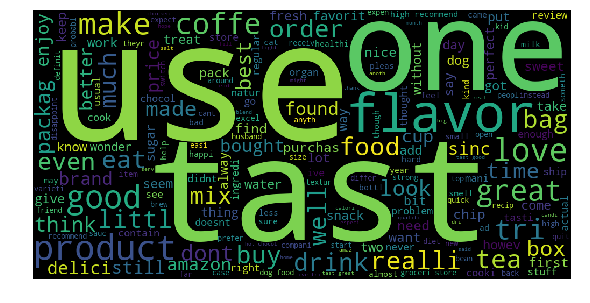

In [54]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 